# Shape descriptors based on neighborhood graphs
This notebook demonstrates how to determine shape descriptors of cells in case they cannot be segmented exactly but their centers can be detected.

In [1]:
from skimage.measure import regionprops
import numpy as np
import pyclesperanto_prototype as cle

cle.get_device()

<gfx90c on Platform: AMD Accelerated Parallel Processing (2 refs)>

We generate a label image of cells with given sizes in x and y and a size ratio of 1:1.5.

Assume this is the result of some cell segmentation algorithm.

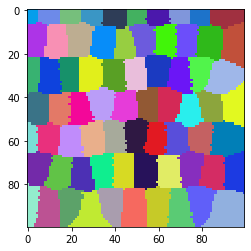

In [2]:
cell_size_x = 10
cell_size_y = 15

# generate and show tissue
tissue_labels = cle.artificial_tissue_2d(width=100, height=100, delta_x=cell_size_x, delta_y=cell_size_y, random_sigma_x=1, random_sigma_y=1)
cle.imshow(tissue_labels, labels=True)

# Classical shape descriptors: minor and major axis
We can measure the minor and major axis of those cells using scikit-image

In [3]:
label_image = cle.pull_zyx(tissue_labels).astype(int)

stats = regionprops(label_image)

avg_minor_axis_length = np.mean([s.minor_axis_length for s in stats])
print("Average minor axis length", avg_minor_axis_length)

avg_major_axis_length = np.mean([s.major_axis_length for s in stats])
print("Average major axis length", avg_major_axis_length)

Average minor axis length 11.094738115993875
Average major axis length 16.966309163176998


We now generate an image where the cells might be hard to segment from, e.g. a membrane image.

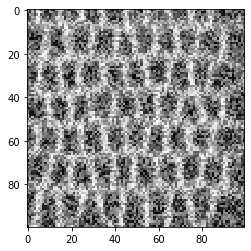

In [4]:
cell_borders = cle.detect_label_edges(label_image)

convolved_membranes = cle.gaussian_blur(cell_borders, sigma_x=1, sigma_y=2)

noise_level = 3
noise = (np.random.random(convolved_membranes.shape) - 0.5) * cle.mean_of_all_pixels(convolved_membranes) * noise_level
noise = noise.astype(np.float32)

artifical_membrane_image = (convolved_membranes + noise)

cle.imshow(artifical_membrane_image)

## Shape descriptors based on neighbor meshes
In some cases, we can't segment the cells properly, we can just do spot detection and visulize the centers of the cells.

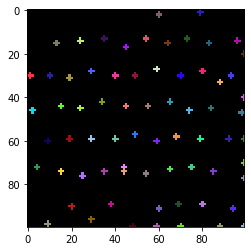

In [5]:
blurred = cle.gaussian_blur(artifical_membrane_image, sigma_x=2, sigma_y=2)

local_minima = cle.detect_minima_box(blurred)

spot_image = cle.label_spots(local_minima)

# we extend the spots a little bit for visualization purposes
spot_image = cle.maximum_sphere(spot_image, radius_x=1, radius_y=1)

cle.imshow(spot_image, labels=True)

From such an image of labelled spots, we can make a voronoi diagram, were we can analyse wich cells (expanded spots) are close by each other.

The result is an approximation of cell segmentation.

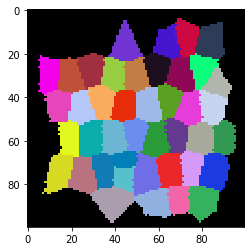

In [6]:
voronoi_diagram_all = cle.extend_labeling_via_voronoi(spot_image)

# exclude labels on image edges
voronoi_diagram = cle.exclude_labels_on_edges(voronoi_diagram_all)

cle.imshow(voronoi_diagram, labels=True)

From such a pair of spots-image and voronoi diagram, we can dermine to matrices, a touch-matrix (also known as adjaceny-graph matrix) and a distance matrix.

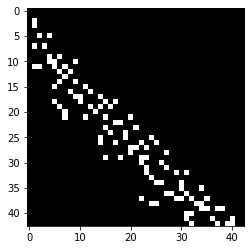

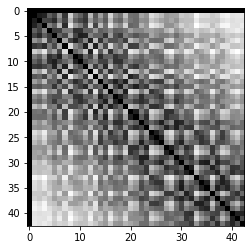

In [7]:
touch_matrix = cle.generate_touch_matrix(voronoi_diagram)

# igonore touching the background
cle.set_column(touch_matrix, 0, 0)


centroids = cle.centroids_of_labels(voronoi_diagram)

distance_matrix = cle.generate_distance_matrix(centroids, centroids)


cle.imshow(touch_matrix)
cle.imshow(distance_matrix)

From these two matrices, we can determine the minimum and maximum distance between centroids of touching objects (cells) in the voronoi image. These are estimated minor and major axis of the segmented objects.

In [8]:
min_distance = cle.minimum_distance_of_touching_neighbors(distance_matrix, touch_matrix)
max_distance = cle.maximum_distance_of_touching_neighbors(distance_matrix, touch_matrix)

print("minimum distance of touching neihbors", cle.mean_of_all_pixels(min_distance))
print("maximum distance of touching neihbors", cle.mean_of_all_pixels(max_distance))

minimum distance of touching neihbors 10.007136855014535
maximum distance of touching neihbors 16.39732325354288


## Distance visualisation
Finally, let's visualize distances between neighbors in a colored mesh.

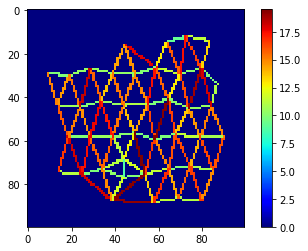

In [9]:
mesh = cle.draw_distance_mesh_between_touching_labels(voronoi_diagram)
cle.imshow(mesh, colorbar=True, colormap="jet")